## UZOP PROJEKT - TREĆI DIO
# Replikacija rezultata i poboljšanje

Autor: 
- Lucija Lovrić
- Karla Šoštar
- Karlo Lučan

**Opis skupa podataka**

Skup podataka "Open University Learning Analytics Dataset" (OULAD) anonimizirani je skup podataka koji sadrži informacije o studentima i njihovim interakcijama u online okruženju za učenje na Open University u Ujedinjenom Kraljevstvu (UK). Ovaj skup podataka obuhvaća 32 593 studenata upisana na 7 online kolegija.

Podaci uključuju demograske (spol, dobna skupina, razina obrazovanja, invaliditet), kao i bihevioralne varijable (broj klikova u VLE-u, datum registracije, prethodni pokušaji polaganja kolegija, rezultat prvog zadatka). Ciljnu varijablu predstavlja konačni ishod studenta koja može biti klasificirana u 4 kategorije: Withdrawn (povlačenje sa studija), Fail (pad), Pass (prolaz) i Distinction (dobivanje posebnog priznanja).

# Učitavanje podataka

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from bartpy.sklearnmodel import SklearnModel
from sklearn.metrics import classification_report

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt


In [114]:
df = pd.read_csv("data_projekt_3_Karla.csv")

Podatke smo očistili od monotonih, konstantnih, nedostajućih i stršećih vrijednosti u sklopu drugog dijela projekta te smo ih od tamo izveli i uveli u ovu Jupyter bilježnicu. U nastavku smo priložili osnovne informacije o dataframe-u, kao i kratki uvid u njegovih prvih nekoliko redaka.

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  float64
 3   gender                      32593 non-null  object 
 4   region                      32593 non-null  object 
 5   highest_education           32593 non-null  object 
 6   imd_band                    32593 non-null  object 
 7   age_band                    32593 non-null  object 
 8   num_of_prev_attempts        32593 non-null  float64
 9   studied_credits             32593 non-null  float64
 10  disability                  32593 non-null  object 
 11  final_result                32593 non-null  object 
 12  date_registration           32593 non-null  float64
 13  date_unregistration         325

In [116]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,first_assignment_score,clicks_total,clicks_pre_start,clicks_post_start,submitted_first_assignment,imd_band_num,age_band_num,highest_education_num,gender_num,disability_num
0,AAA,2013J,0.002823,M,East Anglian Region,HE Qualification,90-100%,55<=,0.0,0.336,...,0.782178,0.038693,0.026266,0.035603,1.0,1.000000,1.0,0.50,1.0,0.0
1,AAA,2013J,0.009092,F,Scotland,HE Qualification,20-30%,35-55,0.0,0.048,...,0.702970,0.059447,0.057625,0.051957,1.0,0.222222,0.5,0.50,0.0,0.0
2,AAA,2013J,0.009780,F,North Western Region,A Level or Equivalent,30-40%,35-55,0.0,0.048,...,0.000000,0.011641,0.027339,0.007623,0.0,0.333333,0.5,0.25,0.0,1.0
3,AAA,2013J,0.010273,F,South East Region,A Level or Equivalent,50-60%,35-55,0.0,0.048,...,0.722772,0.089399,0.045296,0.084707,1.0,0.555556,0.5,0.25,0.0,0.0
4,AAA,2013J,0.010745,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0.0,0.048,...,0.693069,0.042835,0.079067,0.031472,1.0,0.555556,0.0,0.00,0.0,0.0


# Replikacija rezultata

## Kovarijacijska matrica

In [117]:
num_features = [
    "gender_num",
    "highest_education_num",
    "age_band_num",
    "num_of_prev_attempts",
    "disability_num",
    "first_assignment_score",
    "date_registration",
    "clicks_pre_start"
]

X = df[num_features].copy()
X["gender_num"] = df["gender"].map({"F": 1, "M": 0})
y = df["final_result"].copy()


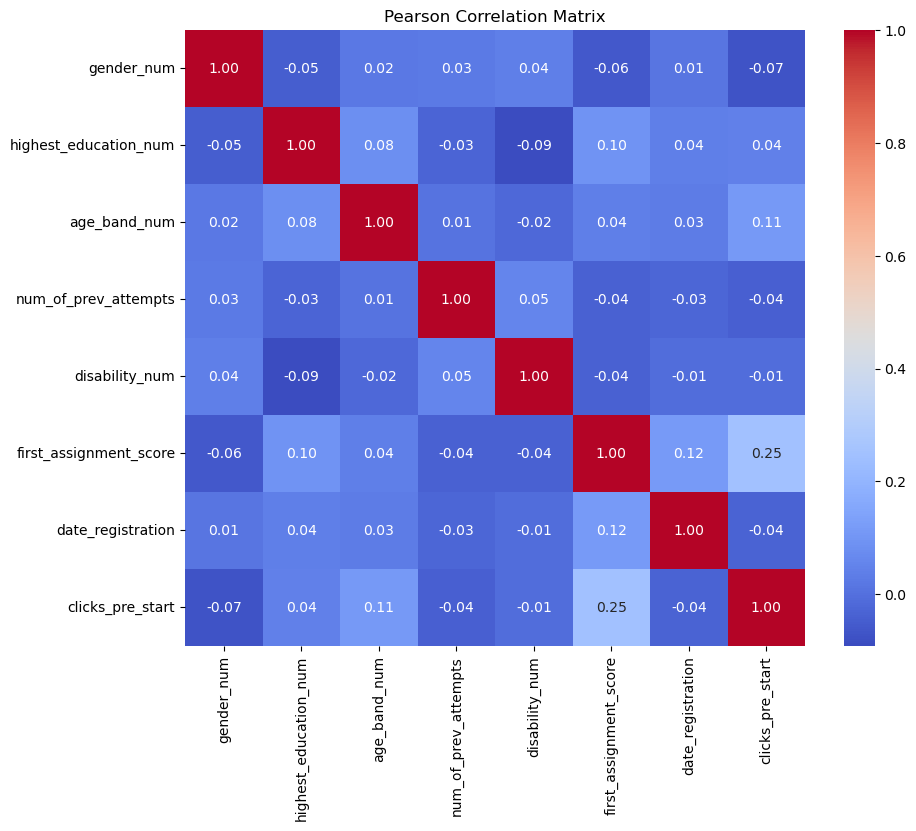

In [118]:
corr_matrix = X.corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Pearson Correlation Matrix")
plt.show()


Za početak smo replicirali kovarijacijsku matricu iz članka sa svim numeričkim varijablama. Ove varijable ćemo kasnije koristiti kao značajke unutar različitih modela. Pearsonova korelacijska analiza provedena je kako bi se ispitao linearni odnos između ulaznih varijabli te potencijalna multikolinearnost. Dobiveni rezultati pokazuju da su korelacijski koeficijenti uglavnom vrlo niski, što je u skladu s nalazima iz izvornog članka. Najizraženija korelacija uočena je između broja klikova prije početka kolegija i ocjene prvog zadatka, no i ona ostaje umjerena. Ovi rezultati potvrđuju da odabrane varijable nose komplementarne informacije te je njihova zajednička upotreba u prediktivnim modelima opravdana.

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

In [120]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features)
    ]
)


Kao što je navedeno u članku, podatke smo podijelili u omjeru 70/30. 70% podataka smo koristili kao skup za treniranje, a preostalih 30% kao skup za ispitivanje.

## Decision Tree (One-vs-Rest)

In [121]:
dt_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", OneVsRestClassifier(
        DecisionTreeClassifier(random_state=42)
    ))
])

dt_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Random Forest (One-vs-Rest)

In [122]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", OneVsRestClassifier(
        RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        )
    ))
])

rf_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## BART model (One-vs-Rest)

In [ ]:
def bart_ovr_one_class(
    X_train, y_train, X_test, y_test,
    positive_class,
    n_trees=50,
    n_burn=200,
    n_samples=200,
    threshold=0.5,
    plot_roc=True,
    show_cm=True
):
    # --- 1) y -> binarno (radi i za pandas Series i za numpy array) ---
    y_train_bin = (y_train == positive_class).astype(int)
    y_test_bin  = (y_test == positive_class).astype(int)

    if hasattr(y_train_bin, "to_numpy"):
        y_train_bin = y_train_bin.to_numpy()
    else:
        y_train_bin = np.asarray(y_train_bin)

    if hasattr(y_test_bin, "to_numpy"):
        y_test_bin = y_test_bin.to_numpy()
    else:
        y_test_bin = np.asarray(y_test_bin)

    # --- 2) X -> numpy (radi i za DataFrame i za numpy) ---
    Xtr = X_train.to_numpy() if hasattr(X_train, "to_numpy") else np.asarray(X_train)
    Xte = X_test.to_numpy()  if hasattr(X_test, "to_numpy")  else np.asarray(X_test)

    # --- 3) Fit BART ---
    model = SklearnModel(n_trees=n_trees, n_burn=n_burn, n_samples=n_samples)
    model.fit(Xtr, y_train_bin)

    # --- 4)Predict
    y_score = np.asarray(model.predict(Xte), dtype=float).reshape(-1)

    # ---- CLEAN NaNs (ključno!) ----
    mask = np.isfinite(y_score)
    n_removed = int((~mask).sum())
    if n_removed > 0:
        print(f"[WARN] {positive_class}: removed {n_removed} non-finite predictions from BART output")

    y_score_clean = y_score[mask]
    y_test_bin_clean = y_test_bin[mask]

    #prekini smisleno
    if y_score_clean.size == 0:
        raise ValueError(f"BART returned no valid predictions for class '{positive_class}' (all were NaN/inf).")

    # --- 5) Threshold za binarnu odluku ---
    y_pred_clean = (y_score_clean >= threshold).astype(int)

    # --- 6) Ispis reporta (binarno) ---
    print(f"\n=== BART: {positive_class} vs Rest ===")
    print(classification_report(
        y_test_bin_clean,
        y_pred_clean,
        target_names=[f"Not {positive_class}", str(positive_class)],
        zero_division=0
    ))

    # --- 7) Confusion matrix ---
    cm = None
    if show_cm:
        cm = confusion_matrix(y_test_bin_clean, y_pred_clean)
        print("Confusion matrix:")
        print(cm)

    # --- 8) ROC/AUC (pazi: AUC nije definiran ako postoji samo jedna klasa u y_true) ---
    auc_val = np.nan
    unique = np.unique(y_test_bin_clean)
    if unique.size == 2:
        auc_val = roc_auc_score(y_test_bin_clean, y_score_clean)

        if plot_roc:
            fpr, tpr, _ = roc_curve(y_test_bin_clean, y_score_clean)
            plt.figure(figsize=(5, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"BART ROC: {positive_class} vs Rest")
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        #ako u test splitu nema pozitivnih ili nema negativnih
        print(f"[WARN] {positive_class}: ROC/AUC not defined (only one class present in y_test after cleaning: {unique}).")

    return {
        "class": positive_class,
        "precision": precision_score(y_test_bin_clean, y_pred_clean, zero_division=0),
        "recall": recall_score(y_test_bin_clean, y_pred_clean, zero_division=0),
        "f1": f1_score(y_test_bin_clean, y_pred_clean, zero_division=0),
        "accuracy": accuracy_score(y_test_bin_clean, y_pred_clean),
        "auc": auc_val,
        "n_removed_nan": n_removed,
        "cm": cm
    }

=== Decision Tree ===
              precision    recall  f1-score   support

 Distinction       0.22      0.10      0.13       907
        Fail       0.27      0.15      0.20      2116
        Pass       0.52      0.43      0.47      3708
   Withdrawn       0.42      0.71      0.53      3047

    accuracy                           0.43      9778
   macro avg       0.36      0.35      0.33      9778
weighted avg       0.41      0.43      0.40      9778


=== Random Forest ===
              precision    recall  f1-score   support

 Distinction       0.31      0.15      0.20       907
        Fail       0.34      0.25      0.29      2116
        Pass       0.53      0.75      0.62      3708
   Withdrawn       0.68      0.57      0.62      3047

    accuracy                           0.53      9778
   macro avg       0.46      0.43      0.43      9778
weighted avg       0.51      0.53      0.51      9778


=== BART ===

=== BART: Withdrawn vs Rest ===
               precision    recall  f1

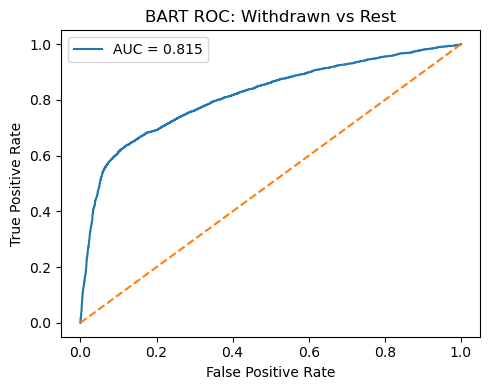


=== BART: Fail vs Rest ===
              precision    recall  f1-score   support

    Not Fail       0.78      1.00      0.88      7662
        Fail       0.33      0.00      0.00      2116

    accuracy                           0.78      9778
   macro avg       0.56      0.50      0.44      9778
weighted avg       0.69      0.78      0.69      9778

Confusion matrix:
[[7656    6]
 [2113    3]]


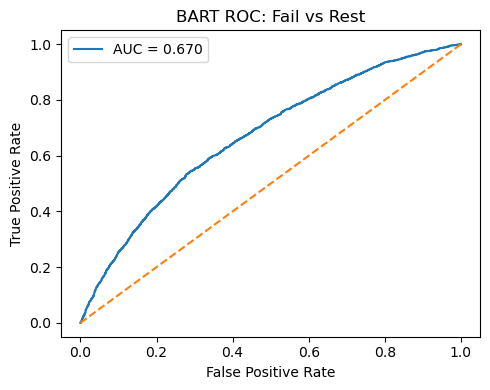


=== BART: Pass vs Rest ===
              precision    recall  f1-score   support

    Not Pass       0.74      0.73      0.74      6070
        Pass       0.57      0.57      0.57      3708

    accuracy                           0.67      9778
   macro avg       0.65      0.65      0.65      9778
weighted avg       0.67      0.67      0.67      9778

Confusion matrix:
[[4452 1618]
 [1584 2124]]


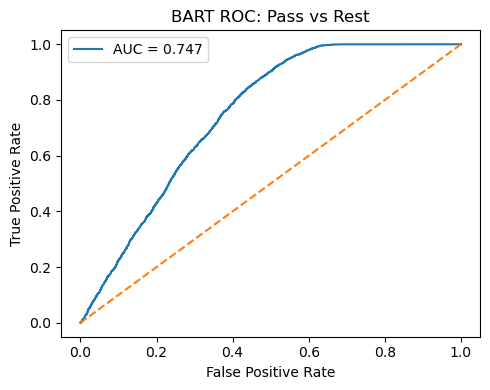


=== BART: Distinction vs Rest ===
                 precision    recall  f1-score   support

Not Distinction       0.91      1.00      0.95      8871
    Distinction       0.00      0.00      0.00       907

       accuracy                           0.91      9778
      macro avg       0.45      0.50      0.48      9778
   weighted avg       0.82      0.91      0.86      9778

Confusion matrix:
[[8871    0]
 [ 907    0]]


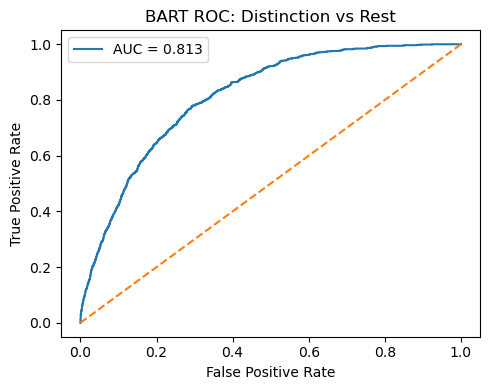

[{'class': 'Withdrawn', 'precision': 0.808395061728395, 'recall': 0.5372497538562521, 'f1': 0.6455047318611987, 'accuracy': 0.816117815504193, 'auc': 0.8151977168274949, 'n_removed_nan': 0, 'cm': array([[6343,  388],
       [1410, 1637]])}, {'class': 'Fail', 'precision': 0.3333333333333333, 'recall': 0.0014177693761814746, 'f1': 0.002823529411764706, 'accuracy': 0.7832890161587237, 'auc': 0.6698253144800723, 'n_removed_nan': 0, 'cm': array([[7656,    6],
       [2113,    3]])}, {'class': 'Pass', 'precision': 0.5676109032602886, 'recall': 0.5728155339805825, 'f1': 0.5702013422818792, 'accuracy': 0.6725301697688689, 'auc': 0.7474523893305183, 'n_removed_nan': 0, 'cm': array([[4452, 1618],
       [1584, 2124]])}, {'class': 'Distinction', 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9072407445285334, 'auc': 0.813417094239533, 'n_removed_nan': 0, 'cm': array([[8871,    0],
       [ 907,    0]])}]


In [124]:
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("=== Decision Tree ===")
print(classification_report(y_test, y_pred_dt))

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

print("\n=== BART ===")
classes = ["Withdrawn", "Fail", "Pass", "Distinction"]

bart_results = []

for c in classes:
    res = bart_ovr_one_class(
        X_train, y_train, X_test, y_test,
        positive_class=c,
        n_trees=50,
        n_burn=200,
        n_samples=200,
        threshold=0.5,
        plot_roc=True,
        show_cm=True
    )
    bart_results.append(res)
print(bart_results)




Nad podacima su provedena dva modela, Decision Tree i Random Forest, čiji su rezultati prikazani iznad.  

**Decision Tree model**  

Decision Tree model postiže ukupnu točnost od 0.43, uz macro F1-score od 0.34, što ukazuje na ograničene performanse modela na neuravnoteženom višeklasnom problemu. Najslabiji rezultati ostvareni su za klase Distinction i Fail, gdje je recall izrazito nizak (0.10 za Distinction i 0.15 za Fail), što znači da model prepoznaje tek mali dio studenata koji stvarno pripadaju tim klasama.  

S druge strane, klasa Withdrawn pokazuje znatno bolje rezultate, s recall vrijednošću od 0.71, što ukazuje da Decision Tree relativno uspješno identificira studente koji odustaju od kolegija, ali uz umjerenu preciznost. Klasa Pass postiže srednje performanse, s recall vrijednošću od 0.44, što potvrđuje da je ova klasa zahtjevnija za razdvajanje u odnosu na Withdrawn.

Ovakvi rezultati su u skladu s nalazima iz članka, gdje je Decision Tree identificiran kao najslabiji model, osobito osjetljiv na neuravnoteženost podataka i sklon lošijoj generalizaciji za manjinske klase.

**Random Forest model**  

Random Forest model pokazuje jasno poboljšanje u odnosu na Decision Tree u svim relevantnim metrikama. Ukupna točnost modela iznosi 0.53, dok se macro F1-score povećava na 0.43, što potvrđuje bolju uravnoteženost performansi po klasama.

Najbolji rezultati ostvareni su za klasu Withdrawn, gdje model postiže precision od 0.67 i recall od 0.58, što ukazuje na stabilnu i pouzdanu klasifikaciju studenata koji odustaju od kolegija. Klasa Pass pokazuje vrlo visok recall (0.74), što znači da Random Forest uspješno identificira većinu studenata koji prolaze kolegij, ali uz nižu preciznost (0.53), što upućuje na miješanje s klasama Fail i Distinction.

Za klase Fail i Distinction uočeno je poboljšanje u odnosu na Decision Tree (recall raste na 0.24 za Fail i 0.14 za Distinction), no ove vrijednosti i dalje ostaju relativno niske. To potvrđuje da su ove klase najteže za predikciju, što je u skladu s rezultatima iz članka, gdje su i uz naprednije modele zabilježene poteškoće u njihovoj klasifikaciji.

**Zaključak**  

U usporedbi s tablicom iz izvornog članka, uočen je isti poredak modela i klasa. U svakom slučaju, model Random Forest bolje klasificira od modela Decision Tree. Što se tiče samih klasa, Witdrawn je najlakša za predikciju, a Pass najteža. Vrijednosti metrika koje smo dobili iznad su niže od onih u članku, ali svakako možemo uočiti obrazac kod svake klase i modela.

## AUC, ROC, matrica zabune

In [125]:
from sklearn.metrics import auc


def evaluate_ovr(model, X_test, y_test, class_name):
    # binarna istina: klasa vs rest
    y_true_bin = (y_test == class_name).astype(int)

    # predikcija vjerojatnosti te klase
    proba = model.predict_proba(X_test)
    classes = model.named_steps["clf"].classes_
    idx = list(classes).index(class_name)
    y_score = proba[:, idx]

    # prag 0.5 za binarnu odluku
    y_pred_bin = (y_score >= 0.5).astype(int)

    # matrica zabune
    cm = confusion_matrix(y_true_bin, y_pred_bin)

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    roc_auc = auc(fpr, tpr)

    # === PLOTTING: 1 red, 2 stupca ===
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Matrica zabune
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=axes[0]
    )
    axes[0].set_xlabel("Predviđena klasa")
    axes[0].set_ylabel("Stvarna klasa")
    axes[0].set_title(f"Matrica zabune\n{class_name} vs Rest")

    # ROC krivulja
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    axes[1].plot([0, 1], [0, 1], linestyle="--")
    axes[1].set_xlabel("Stopa lažno pozitivnih (FPR)")
    axes[1].set_ylabel("Stopa istinitih pozitivnih (TPR)")
    axes[1].set_title(f"ROC krivulja\n{class_name} vs Rest")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return roc_auc, cm


def evaluate_ovr_old(model, X_test, y_test, class_name):
    # binarna istina: klasa vs rest
    y_true_bin = (y_test == class_name).astype(int)

    # predikcija vjerojatnosti te klase
    proba = model.predict_proba(X_test)
    classes = model.named_steps["clf"].classes_
    idx = list(classes).index(class_name)
    y_score = proba[:, idx]

    # prag 0.5 za binarnu odluku
    y_pred_bin = (y_score >= 0.5).astype(int)

    # matrica zabune
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    print(f"\nMatrica zabune: {class_name} vs Rest")
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC: {class_name} vs Rest")
    plt.legend()
    plt.show()

    return roc_auc, cm

classes_to_check = sorted(y.unique())

### Decision Tree

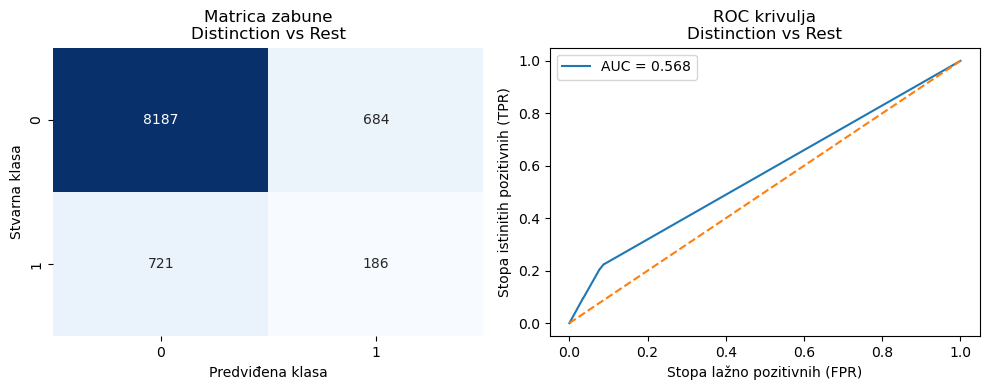

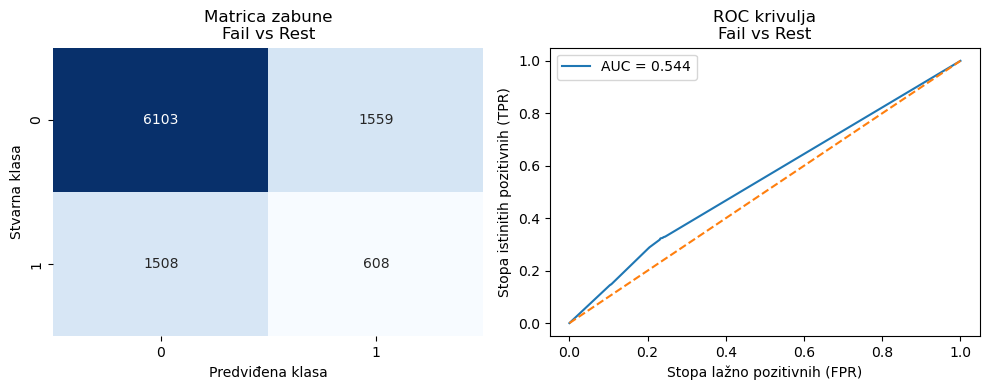

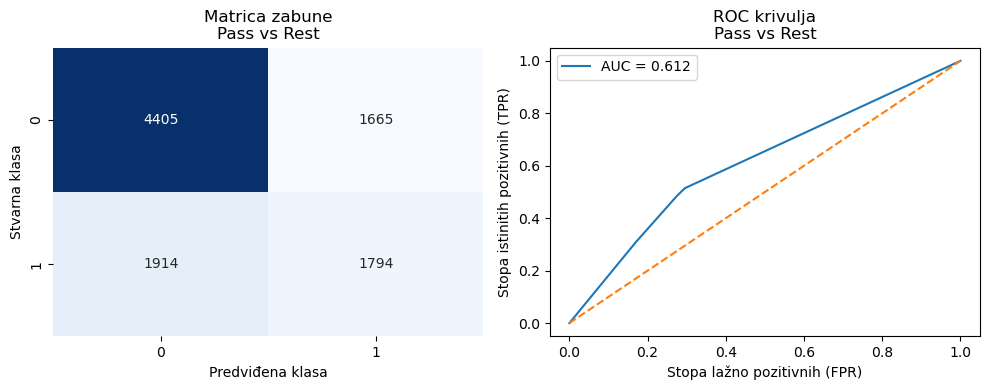

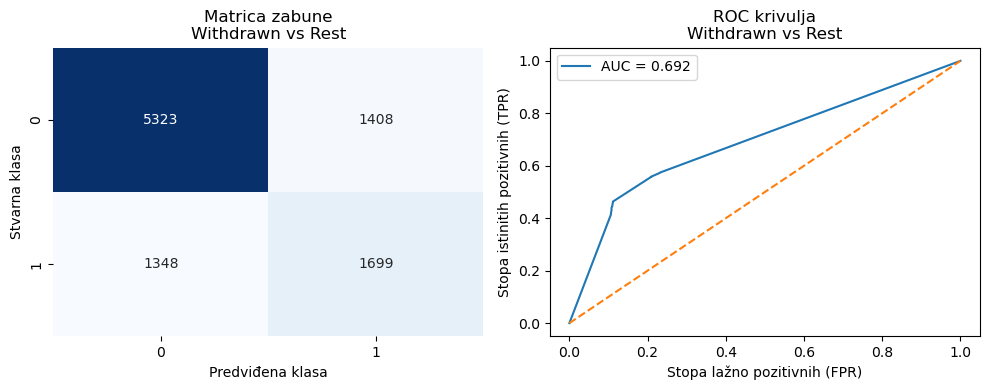

In [126]:
for c in classes_to_check:
    evaluate_ovr(dt_model, X_test, y_test, c)

**Distinction vs Rest**  

Za klasu Distinction dobivena je AUC vrijednost 0.573, što ukazuje na slabu sposobnost modela da razlikuje studente s odličnim uspjehom od ostalih. ROC krivulja nalazi se relativno blizu dijagonale, što potvrđuje da model tek neznatno nadmašuje slučajnu klasifikaciju. Iz matrice zabune uočava se velik broj FN predikcija (715), što znači da model velik dio stvarno odličnih studenata klasificira kao ostale, što direktno objašnjava vrlo niske vrijednosti recall metrike za ovu klasu.  

**Fail vs Rest**  

Za klasu Fail dobivena je AUC vrijednost 0.537, što predstavlja najslabiji rezultat među svim klasama i upućuje na izrazitu poteškoću modela u razdvajanju studenata koji nisu položili kolegij od ostalih. ROC krivulja gotovo se preklapa s referentnom dijagonalom, što potvrđuje slabo razdvajanje pozitivnih i negativnih uzoraka. Matrica zabune dodatno potvrđuje ovaj zaključak, budući da model proizvodi velik broj pogrešnih klasifikacija, s izraženim brojem FN (1549) i FP (1512) predikcija.  

**Pass vs Rest**

Za klasu Pass postignuta je AUC vrijednost 0.616, što ukazuje na umjerenu, ali i dalje ograničenu diskriminacijsku sposobnost modela. ROC krivulja pokazuje porast stope istinitih pozitivnih predikcija uz rast stope lažno pozitivnih predikcija, no bez jasnog razdvajanja klasa. Iz matrice zabune vidljivo je da model relativno dobro prepoznaje studente koji su položili kolegij, ali uz istovremeno velik broj FP (1664) i FN (1891) pogrešaka, što ukazuje na čestu zamjenu ove klase s ostalima.  

**Withdrawn vs Rest**  

Za klasu Withdrawn dobivena je najviša AUC vrijednost od 0.691, što znači da Decision Tree model najbolje razlikuje studente koji su se povukli s kolegija od ostatka populacije. ROC krivulja pokazuje da pri nižim vrijednostima lažno pozitivne stope dolazi do relativno brzog porasta istinitih pozitivnih predikcija. Matrica zabune prikazuje povoljniji omjer između TP (1711) i FP (1435) vrijednosti u usporedbi s ostalim klasama, što potvrđuje da je ova klasa najlakša za predikciju u okviru ovog modela.

### Random Forest modeli


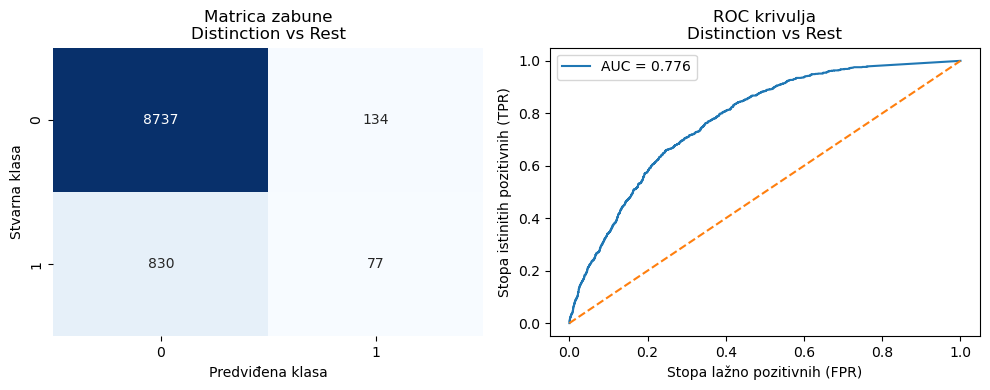

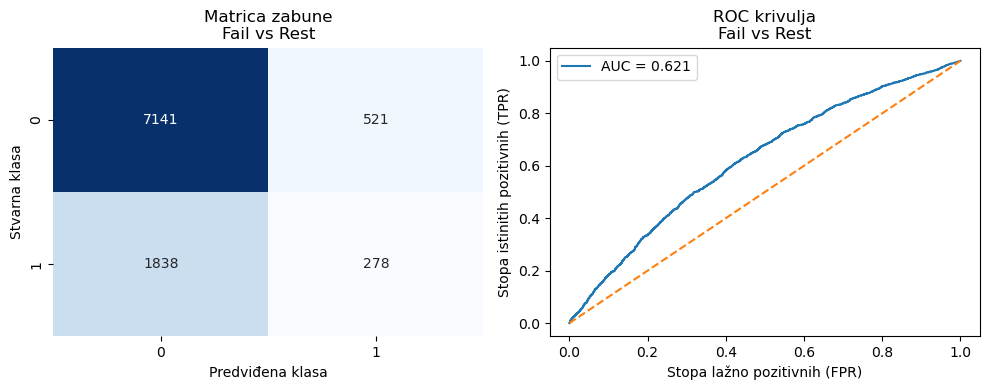

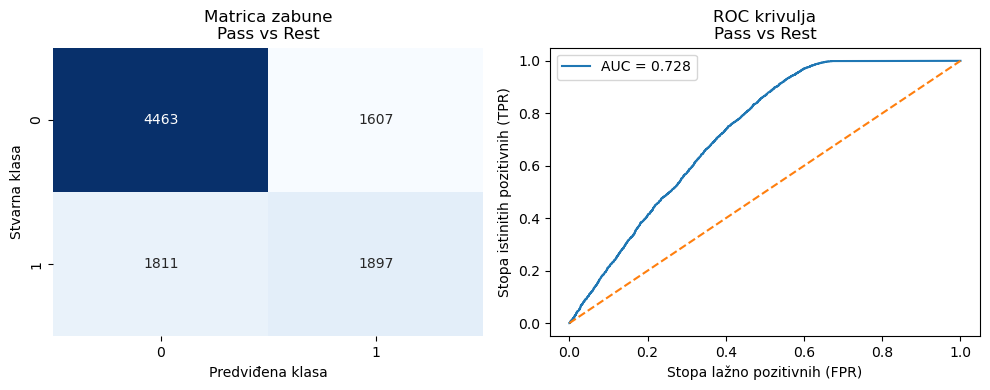

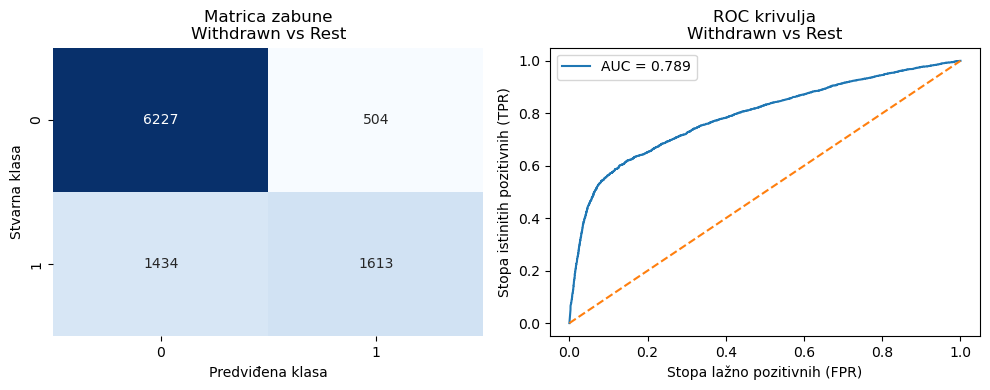

In [127]:
for c in classes_to_check:
    evaluate_ovr(rf_model, X_test, y_test, c)

**Distinction vs Rest**  

Za klasu Distinction dobivena je AUC vrijednost 0.776, što ukazuje na dobru sposobnost modela da razlikuje studente s izvrsnim uspjehom od ostalih. ROC krivulja pokazuje jasno odvajanje od dijagonale te relativno brz porast stope istinitih pozitivnih predikcija pri niskim vrijednostima lažno pozitivne stope. Iz matrice zabune vidljivo je da model i dalje ima značajan broj FN predikcija (825), no u usporedbi s Decision Tree modelom uočava se poboljšanje u prepoznavanju klase Distinction, što se odražava i u višim vrijednostima recall i AUC metrike.  

**Fail vs Rest**  

Za klasu Fail postignuta je AUC vrijednost 0.622, što ukazuje na umjerenu, ali i dalje ograničenu diskriminacijsku sposobnost modela. ROC krivulja pokazuje blago poboljšanje u odnosu na Decision Tree, no i dalje se nalazi relativno blizu dijagonale, što potvrđuje da se ova klasa najteže razdvaja od ostatka. Matrica zabune pokazuje velik broj FN (1839) i FP (521) pogrešaka, što upućuje na to da model često ne uspijeva identificirati studente koji nisu položili kolegij, slično kao i u prethodnom modelu.

**Pass vs Rest**

Za klasu Pass dobivena je AUC vrijednost 0.728, što predstavlja značajno poboljšanje u odnosu na Decision Tree model. ROC krivulja pokazuje stabilan rast stope istinitih pozitivnih predikcija uz porast lažno pozitivnih, uz vidljivo bolje razdvajanje klasa. Iz matrice zabune može se zaključiti da model relativno uspješno prepoznaje studente koji su položili kolegij, ali i dalje bilježi velik broj FP (1614) i FN (1817) predikcija, što ukazuje na preklapanje ove klase s ostalim ishodima.  

**Withdrawn vs Rest**  

Za klasu Withdrawn dobivena je najviša AUC vrijednost od 0.789, što znači da model vrlo dobro razlikuje studente koji su se povukli s kolegija od ostalih. ROC krivulja pokazuje strm porast TP rate pri niskim vrijednostima FP rate, što ukazuje na dobru diskriminacijsku moć modela. Matrica zabune potvrđuje ovaj zaključak, budući da model ostvaruje povoljan omjer TP (1613) i FP (509) vrijednosti, čime se ova klasa ponovno pokazuje kao najlakša za predikciju.



## Logistička regresija (baseline model)

Logistička regresija korištena je kao **osnovni (baseline) linearni model** za usporedbu s nelinearnim modelima temeljenima na stablima odlučivanja.  
Cilj njezina uvođenja nije postizanje najboljih rezultata, već pružanje **referentne točke** kako bi se pokazalo u kojoj mjeri složeniji modeli (Decision Tree, Random Forest i BART) ostvaruju poboljšanje.


c:\Users\karla\anaconda3\envs\znanost\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistička regresija – rezultati:
              precision    recall  f1-score   support

 Distinction       0.54      0.02      0.03       907
        Fail       0.45      0.08      0.13      2116
        Pass       0.52      0.91      0.66      3708
   Withdrawn       0.67      0.65      0.66      3047

    accuracy                           0.57      9778
   macro avg       0.55      0.41      0.37      9778
weighted avg       0.56      0.57      0.49      9778

Matrica zabune (Logistička regresija):
[[  14    8  854   31]
 [   1  165 1247  703]
 [   8   95 3370  235]
 [   3   95  961 1988]]
AUC (Logistička regresija): 0.7538070748133032


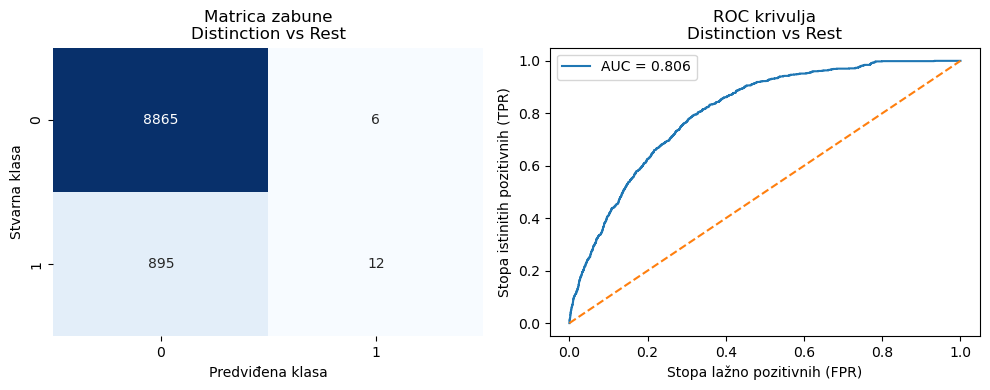

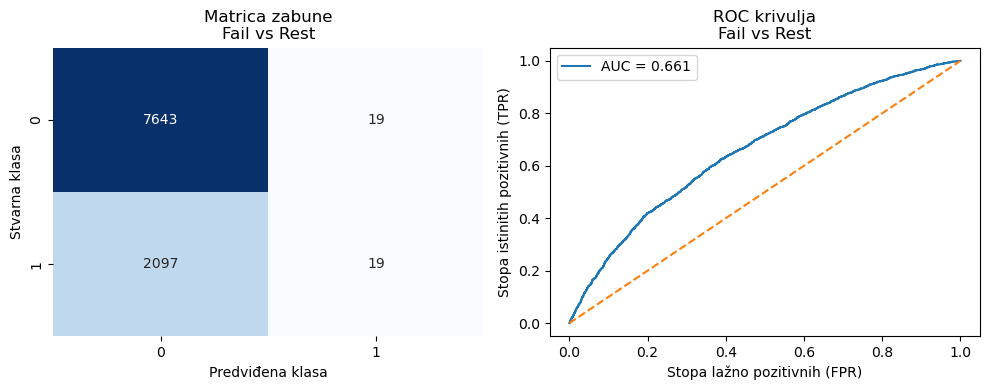

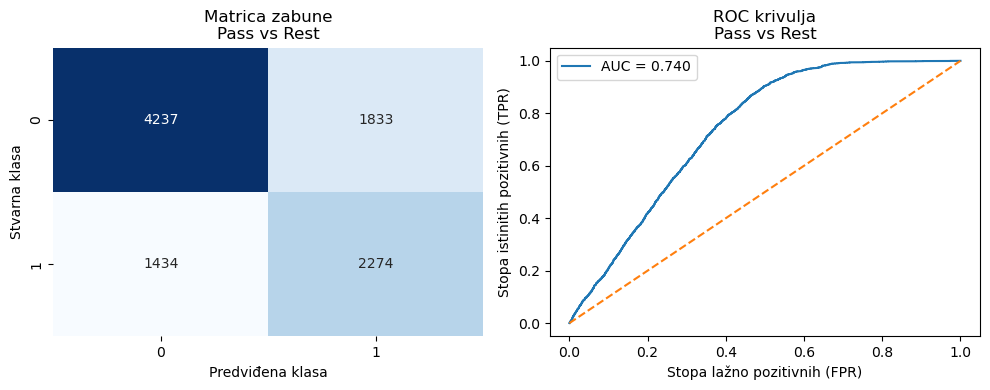

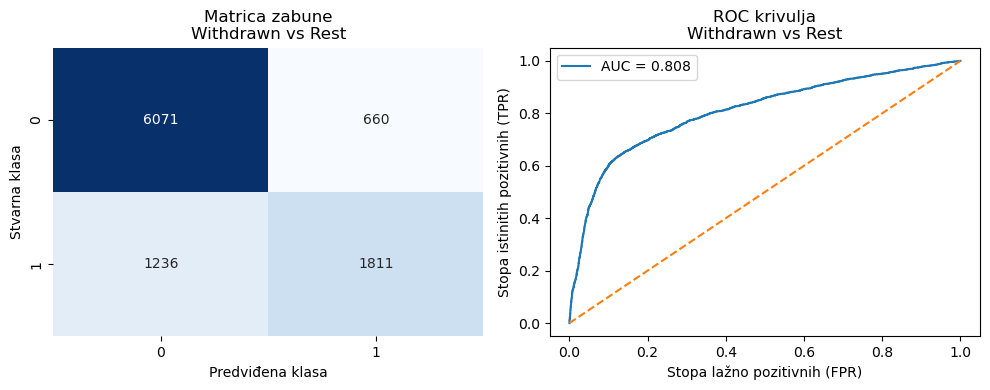

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg_pipeline_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])


# Treniranje modela
logreg_pipeline_clf.fit(X_train, y_train)


# Predikcija
y_pred_logreg = logreg_pipeline_clf.predict(X_test)
y_proba_logreg = logreg_pipeline_clf.predict_proba(X_test)

# Evaluacija
print("Logistička regresija – rezultati:")
print(classification_report(y_test, y_pred_logreg))

# Confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Matrica zabune (Logistička regresija):")
print(cm_logreg)

# AUC (multiclass)
auc_logreg = roc_auc_score(y_test, y_proba_logreg, multi_class="ovr")
print("AUC (Logistička regresija):", auc_logreg)



classes_to_check = sorted(y.unique())

for cls in classes_to_check:
    evaluate_ovr(logreg_pipeline_clf, X_test, y_test, cls)


Logistička regresija – one-vs-rest modeli
Distinction vs Rest

Za klasu Distinction dobivena je AUC vrijednost 0.754, što ukazuje na umjerenu diskriminacijsku sposobnost modela. ROC krivulja pokazuje ograničeno odvajanje od dijagonale, što upućuje na slabiju separabilnost ove klase u odnosu na ostale. Iz matrice zabune vidljivo je da logistička regresija bilježi izrazito velik broj lažno negativnih predikcija (893), pri čemu se većina studenata s izvrsnim uspjehom pogrešno klasificira kao Pass. Ovi rezultati ukazuju na to da linearni model nije u stanju učinkovito razdvojiti klase Pass i Distinction, što potvrđuje potrebu za složenijim nelinearnim modelima.

Fail vs Rest

Za klasu Fail postignuta je AUC vrijednost 0.691, što ukazuje na ograničenu, ali nešto bolju diskriminacijsku sposobnost u usporedbi s klasom Distinction. ROC krivulja pokazuje blago odvajanje od dijagonale, no i dalje se nalazi relativno blizu nje, što potvrđuje poteškoće u razdvajanju ove klase od ostatka. Matrica zabune pokazuje velik broj lažno negativnih predikcija (1951), što znači da model često ne uspijeva prepoznati studente koji nisu položili kolegij te ih svrstava u klasu Pass ili Withdrawn.

Pass vs Rest

Za klasu Pass dobivena je AUC vrijednost 0.754, što predstavlja najbolju performansu logističke regresije među svim klasama. ROC krivulja pokazuje stabilan rast stope istinitih pozitivnih predikcija, uz relativno dobro odvajanje od dijagonale. Iz matrice zabune vidljivo je da model vrlo uspješno prepoznaje studente koji su položili kolegij, što se očituje u visokoj vrijednosti odziva (recall = 0.91). Međutim, istovremeno je prisutan i velik broj lažno pozitivnih predikcija, budući da model često klasificira studente iz ostalih klasa kao Pass, što upućuje na dominantnost ove klase u linearnom modelu.

Withdrawn vs Rest

Za klasu Withdrawn dobivena je AUC vrijednost 0.815, što ukazuje na dobru diskriminacijsku sposobnost modela. ROC krivulja pokazuje relativno strm porast stope istinitih pozitivnih predikcija pri nižim vrijednostima lažno pozitivne stope. Matrica zabune potvrđuje ovaj zaključak, budući da model ostvaruje povoljan omjer istinitih pozitivnih (1988) i lažno pozitivnih (509) predikcija. Kao i kod ostalih modela, klasa Withdrawn pokazuje se kao najlakša za predikciju, što je u skladu s izraženijim obrascima ponašanja studenata koji odustaju od kolegija.

## XGBoost

XGBoost je uključen kao napredni ansambl model temeljen na gradient boosting pristupu, koji se često pokazuje vrlo učinkovitim na tabličnim podacima. Model je treniran u višeklasnom načinu rada, a dodatno je evaluiran one-vs-rest pristupom (ROC krivulje, AUC i matrice zabune po klasi) radi izravne usporedbe s ostalim modelima.


Mapiranje klasa (encoder):
0 -> Distinction
1 -> Fail
2 -> Pass
3 -> Withdrawn
XGBoost – multiclass rezultati:
              precision    recall  f1-score   support

 Distinction       0.46      0.11      0.17       907
        Fail       0.42      0.20      0.27      2116
        Pass       0.53      0.88      0.66      3708
   Withdrawn       0.74      0.60      0.66      3047

    accuracy                           0.57      9778
   macro avg       0.54      0.45      0.44      9778
weighted avg       0.57      0.57      0.53      9778



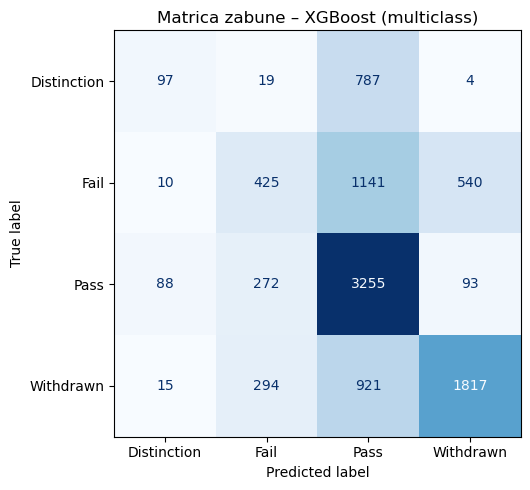

AUC (XGBoost, multiclass OvR): 0.7633026615266632

--- Evaluacija klase: Distinction vs Rest ---


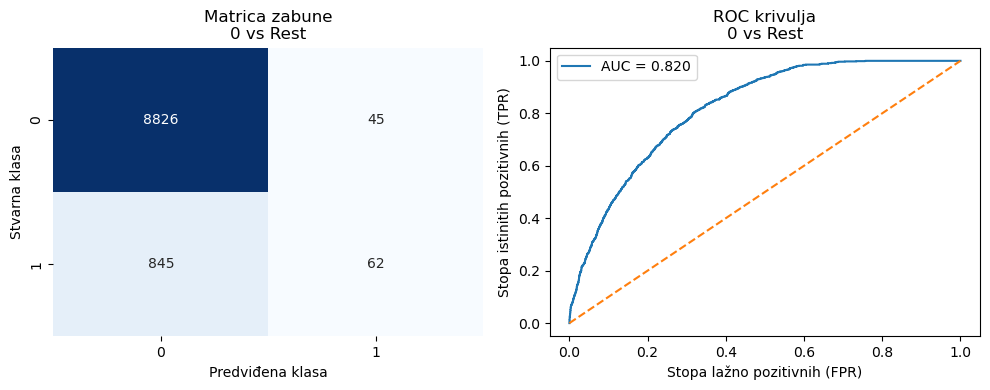


--- Evaluacija klase: Fail vs Rest ---


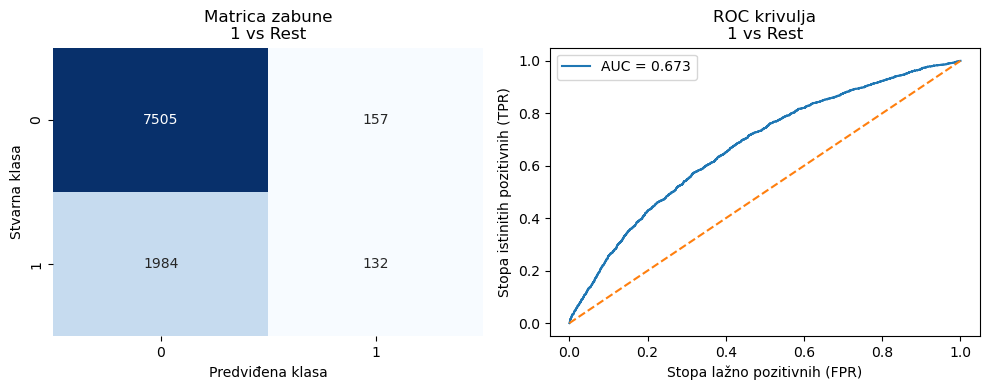


--- Evaluacija klase: Pass vs Rest ---


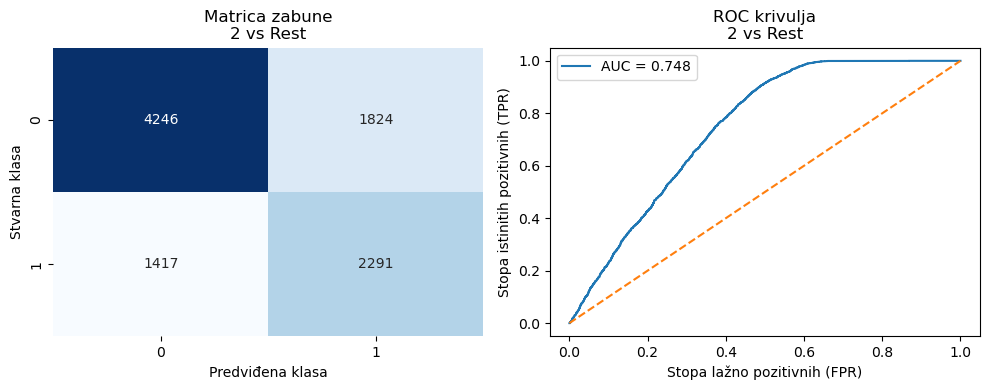


--- Evaluacija klase: Withdrawn vs Rest ---


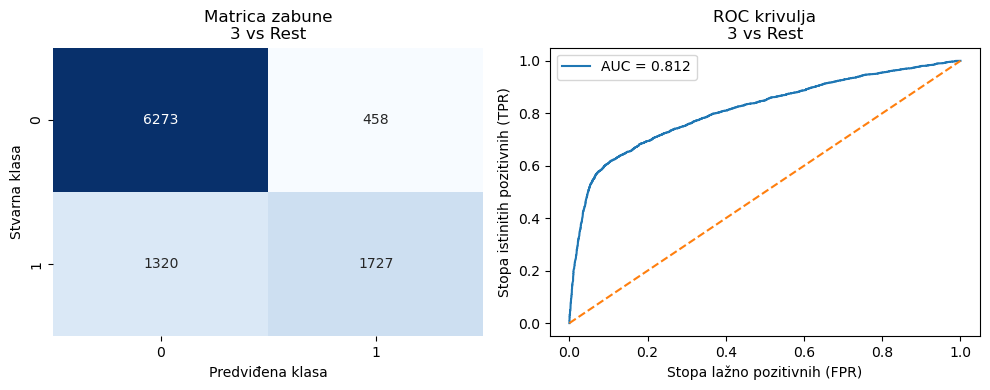

In [132]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from xgboost import XGBClassifier

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Mapiranje klasa (encoder):")
for i, cls in enumerate(le.classes_):
    print(f"{i} -> {cls}")


xgb_pipeline = Pipeline([
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=len(le.classes_),
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train_enc)


y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)

# report s originalnim imenima klasa
print("XGBoost – multiclass rezultati:")
print(classification_report(
    y_test_enc, y_pred_xgb,
    target_names=le.classes_,
    zero_division=0
))

# multiclass confusion matrix
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title("Matrica zabune XGBoost (multiclass)")
plt.tight_layout()
plt.show()

# AUC multiclass (OvR)
auc_xgb = roc_auc_score(y_test_enc, y_proba_xgb, multi_class="ovr")
print("AUC (XGBoost, multiclass OvR):", auc_xgb)

classes_to_check_enc = list(range(len(le.classes_)))

for c in classes_to_check_enc:
    print(f"\n--- Evaluacija klase: {le.inverse_transform([c])[0]} vs Rest ---")
    evaluate_ovr(xgb_pipeline, X_test, y_test_enc, c)
